Adding confounder variates into regression when calculating treatment effect is a must. But in real world, there can be too many varibles to identify, and if we bindly adding all of them can be detrimental.

# Confounder & Pre-Treatment Covariates

Consider we're working on an experiment of sending email(treatment) to debtors and check the effect on their payment returns(outcome).

In [24]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
import os

style.use("fivethirtyeight")

In [25]:
url_base = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/"
file = "collections_email.csv"
data = pd.read_csv(os.path.join(url_base, file))
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


Assume the experiment is fully randomised.

In [3]:
model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


The treatment turns out be negative and the p-value is too big to conclude. But notice here that __credit_limit__ and __risk_score__ that exist pre-treatment can be a strong covariate to explain the outcome.

__Including pre-treatment variables that can explain the outcome can help reduce variance.__ In regression, when we include a variable, we keep it controlled, that is when fix the variable, we should see that people with similar __risk_score__ should have similar __payments__, which reduces the variance.

In [10]:
pre_var = data["payments"].var()
post_var = data[(data["risk_score"] >= 0.3) & (data["risk_score"] <= 0.4)]["payments"].var()

print(f"original var: {pre_var:.2f}, fix risk_score var: {post_var:.2f}")

original var: 10809.77, fix risk_score var: 5985.08


<Axes: xlabel='risk_score', ylabel='payments'>

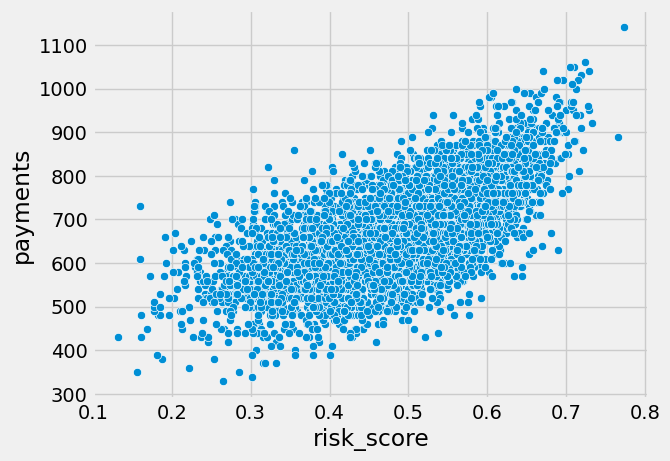

In [4]:
sns.scatterplot(x="risk_score", y="payments", data=data)

We can get this by regressing on the residuals, not that if email group is totally random, the covariates would not be able to explain __email__, thus not reducing any of the variance of email.

In [14]:
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()

In [15]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

model_treatment.summary().tables[1]

Payments Variance 10807.612416
Payments Residual Variance 5652.453558466207
Email Variance 0.24991536
Email Residual Variance 0.24918421069820032


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.719e-14,1.063,-3.5e-14,1.000,-2.084,2.084
res_email,4.4304,2.129,2.080,0.038,0.256,8.605


In [23]:
# [Optional]this also works
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, email=data["email"]))

t1 = smf.ols('res_payments ~ email', data=residuals).fit().summary().tables[1]

t2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit().summary().tables[1]

print(t1, t2)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1681      1.490     -1.455      0.146      -5.088       0.752
email          4.4174      2.126      2.077      0.038       0.249       8.586
============================================================================== ================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      490.8653      9.715     50.527      0.000     471.820     509.911
email            4.4304      2.130      2.080      0.038       0.255       8.606
credit_limit     0.1511      0.008     18.833      0.000       0.135       0.167
risk_score      -8.0516     38.424     -0.210      0.834     -83.379      67.276


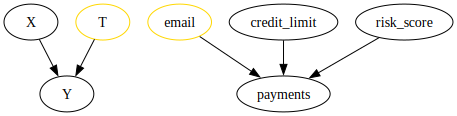

In [18]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

# Harmful Covariates

Consider a treatment applied to patients in two different hospitals, and the outcome is the number of days hospitalised.

_However, the treatment is not applied equally, severe patients are more likely to receive a treatment and severe are also more likely to be sent to one of the hospitals._

In [26]:
hospital = pd.read_csv(os.path.join(url_base, "hospital_treatment.csv"))
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


In [27]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


In this formula, it seems that treatment actually prolongs the hospitalisation. But clearly, there's a confounder here, which is __severity__, it affects both the outcome days as well as the treatment received. 

Adding in severity actually solves the problem.

In [28]:
hosp_2 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


There's another covariate __hospital__ which affects the treatment a patient receives, but it is independent to our outcome once with severity controlled. 

> __When adding a covariate that explains the treatment but not the outcome, it provides biased result.__


In [32]:
hosp_3 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


We see that the __std_err__ has increased to `3.492` after adding hospital as a covariate and the result becomes in-conclusive.

In [33]:
# hosp_3 = smf.ols('days ~ treatment + hospital', data=hospital).fit()
# hosp_3.summary().tables[1]

The variance of $\beta$ is calculated by

$$\hat{\sigma}^{2} = \frac{1}{n-2}\sum(y_i - \hat{y_i})^2$$

$$Var(\hat{\beta}) = \frac{\hat{\sigma^{2}}}{\sum(x_i - \bar{x_i})^2}$$

We can see that lower the variance of $X$, here is the treatment, higher the variance. It means that if the treatment is of very low variance, it is harder to reach a conclusion. Which makes intuitive sense, if in an experiment, most people got treatment and almost none of them didn't receive a treatment, it's going to be really hard to get a conclusive results as the data is not diverse enough.

In this case, when we control for __hospital__, the people in the same hospital mostly either receive or not receive a treatment, so it becomes less diverse.

In [51]:
# this equivalent to the above
model_treatment = smf.ols('treatment ~ severity + hospital', data=hospital).fit()
model_days = smf.ols('days ~ severity + hospital', data=hospital).fit()

residuals = pd.DataFrame(dict(res_days=model_days.resid, res_treatment=model_treatment.resid))

model = smf.ols('res_days ~ res_treatment', data=residuals).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.06e-14,0.827,2.49e-14,1.000,-1.646,1.646
res_treatment,-5.0945,3.447,-1.478,0.143,-11.957,1.768


In [52]:
print("Treatment Variance", np.var(hospital["treatment"]))
print("Treatment Residual Variance", np.var(residuals["res_treatment"]))

Treatment Variance 0.234375
Treatment Residual Variance 0.057529091872119076


In [55]:
sigma_hat = sum(model.resid**2)/(len(model.resid)-2)
var = sigma_hat/sum((model_treatment.resid - model_treatment.resid.mean())**2)
print("SE of the Coeficient:", np.sqrt(var))

SE of the Coeficient: 3.446973767486902


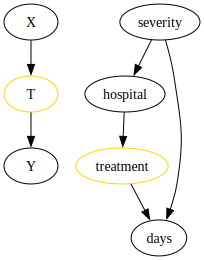

In [56]:
g = gr.Digraph()

g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g

# Selection Bias

Confounders are the common __cause__ of treatment and outcome. Selection bias is 

1. a common effect of both Treatment & Outcome.
2. Or a mediator between Treatment & Outcome.

In the example above, `opened` is whether the guy has opened the email, and `agreement` is whether he/she reached an agreement on the debt after receiving the email. They all caused by treatment, adding them in will block the effect of the treatment!

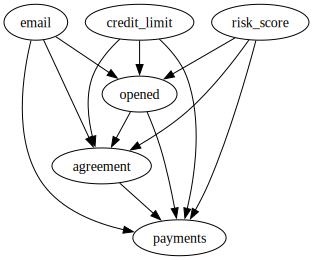

In [58]:
g = gr.Digraph()

g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

In [57]:
email_2 = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=data).fit()
email_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,488.4416,9.716,50.272,0.000,469.394,507.489
email,-1.6095,2.724,-0.591,0.555,-6.949,3.730
credit_limit,0.1507,0.008,18.809,0.000,0.135,0.166
risk_score,-2.0929,38.375,-0.055,0.957,-77.325,73.139
opened,3.9808,3.914,1.017,0.309,-3.692,11.654
agreement,11.7093,4.166,2.811,0.005,3.542,19.876


# Summary of Bad Controls/Covariates

This includes

1. X in between Treatment and Outcome.
2. X is a common effect of Treatment and Outcome.

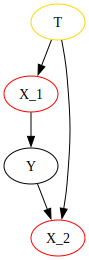

In [59]:
g = gr.Digraph()

g.edge("T", "X_1"), g.node("T", color="gold"), g.edge("X_1", "Y"), g.node("X_1", color="red")
g.edge("T", "X_2"), g.edge("Y", "X_2"), g.node("X_2", color="red")

g